[Data](https://drive.google.com/file/d/1UR2xtmZPkCByficxI-v_dVUP8_cX-tPn/view) was taken from this [tutorial](https://pylessons.com/TensorFlow-CAPTCHA-solver-training/)

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T

import numpy as np
from PIL import Image
from os.path import join
from os import listdir
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.pyplot import figure

from tqdm import tqdm

from xml.etree import ElementTree

torch.cuda.set_device('cuda:1')

In [2]:
path = '/home/egor/job/CAPTCHA_recognition/data/labels+boxes'

# EDA

In [3]:
train_jpg_names = [name for name in listdir(join(path, 'train')) if '.jpg' in name]
test_jpg_names = [name for name in listdir(join(path, 'test')) if '.jpg' in name]

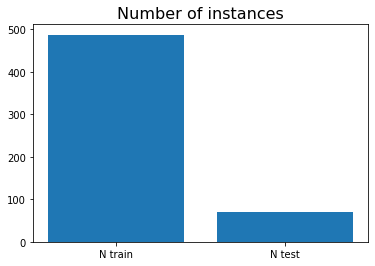

In [4]:
plt.bar(np.arange(2), [len(train_jpg_names), len(test_jpg_names)]);
plt.xticks(np.arange(2), ('N train', 'N test'));
plt.title('Number of instances', fontsize=16)
plt.show()

### Examine images

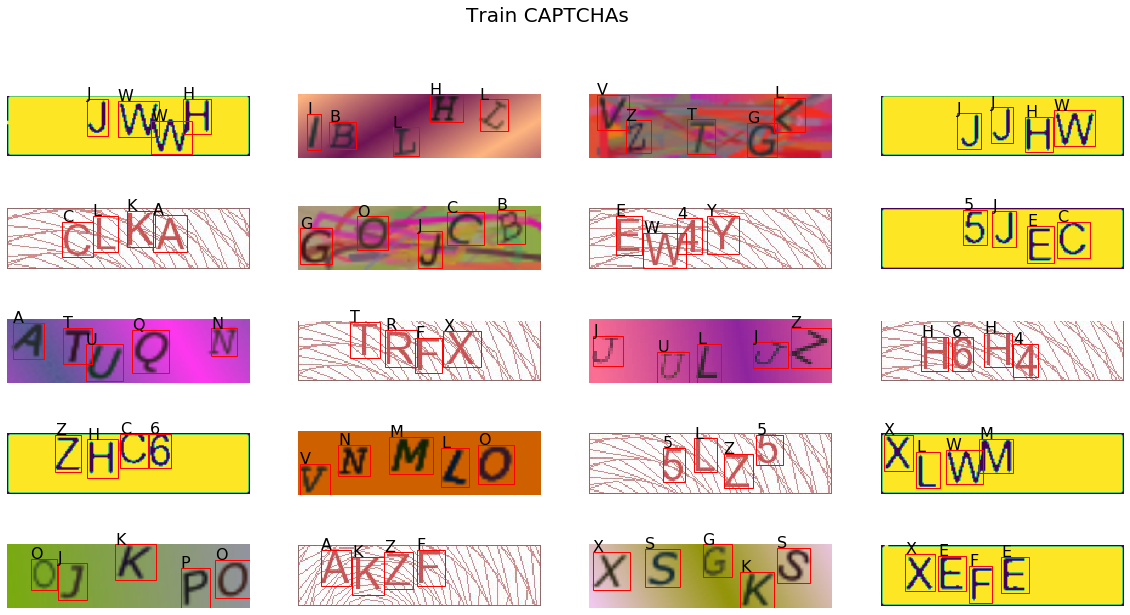

In [5]:
f, ax = plt.subplots(5, 4, figsize=(20, 10))
f.suptitle('Train CAPTCHAs', fontsize=20)
for i in range(20):
    img = np.array(Image.open(join(path, 'train', train_jpg_names[i])))
    row, col = i // 4, i % 4
    
    xml_name = train_jpg_names[i][:-3] + 'xml'
    xml = ElementTree.parse(join(path, 'train', xml_name)).getroot()
    for obj in xml.iter('object'):
        bndbox = obj.find('bndbox')
        x0, y0 = int(bndbox.find('xmin').text), int(bndbox.find('ymin').text)
        x1, y1 = int(bndbox.find('xmax').text), int(bndbox.find('ymax').text)
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax[row, col].add_patch(rect)
        ax[row, col].text(x0, y0, obj.find('name').text, fontsize=16)
        
    ax[row, col].axis('off')
    ax[row, col].imshow(img)

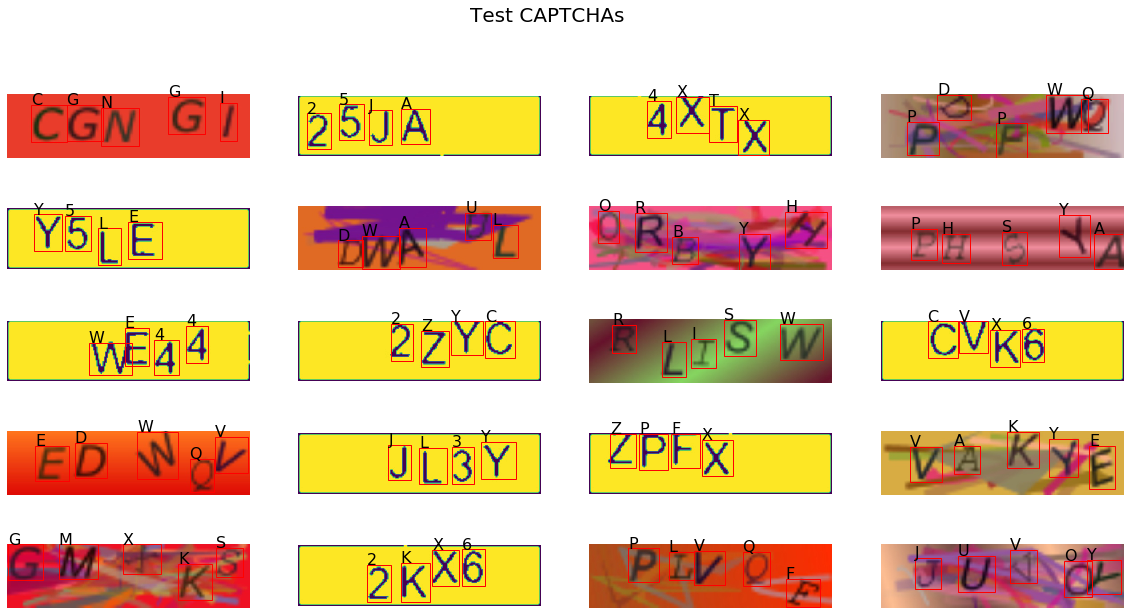

In [6]:
f, ax = plt.subplots(5, 4, figsize=(20, 10))
f.suptitle('Test CAPTCHAs', fontsize=20)
for i in range(20):
    img = np.array(Image.open(join(path, 'test', test_jpg_names[i])))
    row, col = i // 4, i % 4
    
    xml_name = test_jpg_names[i][:-3] + 'xml'
    xml = ElementTree.parse(join(path, 'test', xml_name)).getroot()
    for obj in xml.iter('object'):
        bndbox = obj.find('bndbox')
        x0, y0 = int(bndbox.find('xmin').text), int(bndbox.find('ymin').text)
        x1, y1 = int(bndbox.find('xmax').text), int(bndbox.find('ymax').text)
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax[row, col].add_patch(rect)
        ax[row, col].text(x0, y0, obj.find('name').text, fontsize=16)
        
    ax[row, col].axis('off')
    ax[row, col].imshow(img)

### Image resolutions

In [7]:
def get_unique_res(_path, names):
    unique_res = set()
    
    for name in names:
        xml_name = name + '.xml'
        xml = ElementTree.parse(join(_path, xml_name)).getroot()

        size = xml.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)   

        unique_res.add((width, height))
        
    return list(unique_res)

Dataset was made by an ordinary fellow I suppose. So data is a little bit imbalanced. And here we see that in some xmls spatial data is corrupted.

In [8]:
print('Train resolutions')
print(get_unique_res(join(path, 'train'), [name[:-4] for name in train_jpg_names]))
print('Test resolutions')
print(get_unique_res(join(path, 'test'), [name[:-4] for name in test_jpg_names]))

Train resolutions
[(546, 144), (0, 0), (200, 50), (400, 100)]
Test resolutions
[(546, 144), (400, 100)]


### Token distribution

In [9]:
def count_symbols(path):
    freqs = {}
    xmls = [name for name in listdir(path) if '.xml' in name]
    
    for xml_name in xmls:
        
        xml = ElementTree.parse(join(path, xml_name)).getroot()
        
        for obj in xml.iter('object'):
            label = obj.find('name').text.lower()
            
            if label in freqs:
                freqs[label] += 1
            else:
                freqs[label] = 1
        
    return freqs


def print_freq_list(freq_dict):
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    freq_list = [(token, freq) for token, freq in freq_dict.items()]
    freq_list = sorted(freq_list, key=lambda x: x[0])

    plt.bar(range(len(freq_list)), [i[1] for i in freq_list], align='center')
    plt.xticks(range(len(freq_list)), [i[0] for i in freq_list])
    plt.show()

It's interesting, that some digits are absent on CAPTCHAs. Suppose 0, 1, 7, 8, 9 look like some letters and it's hard to distinguish between them.

In [10]:
train_freq = count_symbols(join(path, 'train'))

In [11]:
vocab = ['1','2','3','4','5','6','7','8','9','0','A','B','C','D','E','F','G','H','I','J','K', \
         'L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# add not used symbols
for token in vocab:
    token = token.lower()
    if token not in train_freq:
        train_freq[token] = 0

Token distribution in train set


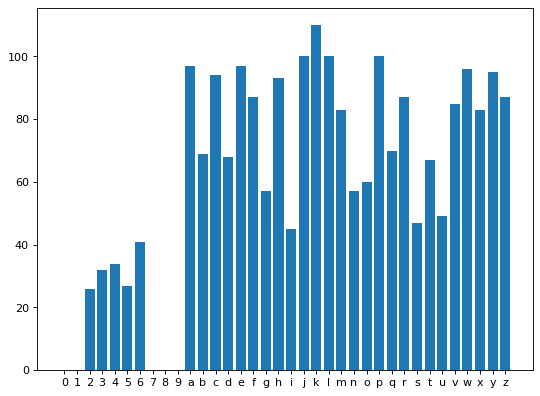

In [12]:
print('Token distribution in train set')
print_freq_list(train_freq)

In [13]:
test_freq = count_symbols(join(path, 'test'))

In [14]:
# add not used symbols
for token in vocab:
    token = token.lower()
    if token not in test_freq:
        test_freq[token] = 0

Token distribution in test set


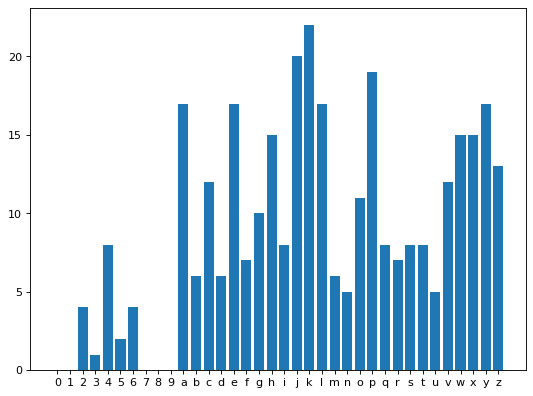

In [15]:
print('Token distribution in test set')
print_freq_list(test_freq)

So from EDA I learnt that in train we have some CAPTCHAs which is absent in test. We also don't have some digits at all. At least data train and test distibutions don't differs much. 

# Detection

## Data preperation

In [3]:
class CAPTCHA_dataset(Dataset):
    
    def __init__(self, path, img_transforms=[T.ToTensor()], vocab=None, use_gpu=True):
        self.use_gpu = use_gpu
        self.transform = T.Compose(img_transforms)
        self._img_names = sorted([name for name in listdir(join(path)) if '.jpg' in name])
        self._xml_names = sorted([name for name in listdir(join(path)) if '.xml' in name])
        
        # check if image names correspond to xml names
        for img_name, xml_name in zip(self._img_names, self._xml_names):
            if not img_name[:-4] == xml_name[:-4]:
                raise ValueError(f'img {img_name} does not correspont to xml {xml_name}')
        
        self.images = []
        for img_name in self._img_names:
            self.images.append(np.array(Image.open(join(path, img_name)).convert('RGB')))
       
        self.boxes = []
        self.labels = []
        for xml_name in self._xml_names:
            cur_labels, cur_boxes = [], []
            xml = ElementTree.parse(join(path, xml_name)).getroot()
            for obj in xml.iter('object'):
                bndbox = obj.find('bndbox')
                x0, y0 = int(bndbox.find('xmin').text), int(bndbox.find('ymin').text)
                x1, y1 = int(bndbox.find('xmax').text), int(bndbox.find('ymax').text)
                cur_boxes.append((x0, y0, x1, y1))
                cur_labels.append(obj.find('name').text)
            self.boxes.append(cur_boxes)
            self.labels.append(cur_labels)
            
        if vocab:
            self.vocab = vocab
        else:
            self.vocab = list(set([char for chars in self.labels for char in chars]))
            
        self.lbl2indx = {lbl: indx for indx, lbl in enumerate(self.vocab)}
        self.indx2lbl = {indx: lbl for lbl, indx in self.lbl2indx.items()}
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, indx):
        img = self.transform(self.images[indx])
        labels = torch.LongTensor([self.lbl2indx[char] for char in self.labels[indx]])
        boxes = torch.tensor(self.boxes[indx], dtype=torch.float32)
        
        if self.use_gpu:
            img = img.cuda()
            labels = labels.cuda()
            boxes = boxes.cuda()
        
        # target should be list of dicts. Dicts must containe boxes and labels keys
        # boxes (Tensor[N, 4]): the ground-truth boxes in [x0, y0, x1, y1] format, 
        #                       with values between 0 and H and 0 and W
        # labels (Tensor[N]): the class label for each ground-truth box
        target = {'boxes': boxes, 'labels': labels}
        return img, target
    

def custom_collate(batch):
    imgs = [i[0] for i in batch]
    targets = [i[1] for i in batch]
    
    return imgs, targets

There is only train and test folders. I need validation data. It will be 15% of train data

In [4]:
val_path = join(path, 'val')

!mkdir $val_path

In [5]:
np.random.seed(42)

train_jpgs = sorted([name for name in listdir(join(path, 'train')) if '.jpg' in name])
train_xmls = sorted([name for name in listdir(join(path, 'train')) if '.xml' in name])

for jpg, xml in zip(train_jpgs, train_xmls):
    assert jpg[:-4] == xml[:-4]
    
val_length = int(0.15 * 0.5 * len(listdir(join(path, 'train'))))
indxes = np.random.permutation(range(len(train_jpgs)))[:val_length]

for indx in tqdm(indxes, desc='Moving pictures'):
    from_jpg = join(path, 'train', train_jpgs[indx])
    from_xml = join(path, 'train', train_xmls[indx])
    to_jpg = join(path, 'val', train_jpgs[indx])
    to_xml = join(path, 'val', train_xmls[indx])
    
    !mv $from_jpg $to_jpg
    !mv $from_xml $to_xml

Moving pictures: 100%|██████████| 73/73 [00:17<00:00,  4.10it/s]


checks that dataset works

In [6]:
vocab = ['1','2','3','4','5','6','7','8','9','0','A','B','C','D','E','F','G','H','I','J','K', \
         'L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

In [7]:
train_dataset = CAPTCHA_dataset(join(path, 'train'), vocab=vocab)
val_dataset = CAPTCHA_dataset(join(path, 'val'), vocab=vocab)
test_dataset = CAPTCHA_dataset(join(path, 'test'), vocab=vocab)

## Training

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(n_labels):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    num_classes = n_labels
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [9]:
def train(model, loader, optimizer, epoch=None, lr_scheduler=None):
    model.train()
    
    if epoch: tqdm_text = f'Training {epoch} epoch'
    else:  tqdm_text = f'Training'
        
    epoch_loss = 0.
    for images, targets in tqdm(loader, desc=tqdm_text):
        
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if lr_scheduler:
            lr_scheduler.step()
            
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)


def evaluate(model, loader, epoch=None):
    # model has complicated set of losses so I wont calculate them myself
    # loss_dict is only returned in train mode thats why I use train mode
    # in evaluation function
    model.train()
    
    if epoch: tqdm_text = f'Evaluating {epoch} epoch'
    else:  tqdm_text = f'Evaluating'
    
    epoch_loss = 0.
    with torch.no_grad():
        for images, targets in tqdm(loader, desc=tqdm_text):
        
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

In [10]:
config = dict(
    epochs = 12,
    bs = 4,
)

vocab = ['1','2','3','4','5','6','7','8','9','0','A','B','C','D','E','F','G','H','I','J','K', \
         'L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

train_dataset = CAPTCHA_dataset(join(path, 'train'), vocab=vocab)
val_dataset = CAPTCHA_dataset(join(path, 'val'), vocab=vocab)
test_dataset = CAPTCHA_dataset(join(path, 'test'), vocab=vocab)

train_loader = DataLoader(train_dataset, config['bs'], collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, config['bs'], collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, config['bs'], collate_fn=custom_collate)

In [11]:
model = get_model(len(vocab))
model.cuda()

param_groups = [
    {'params': model.backbone.body.conv1.parameters()},
    {'params': model.backbone.body.layer1.parameters()},
    {'params': model.backbone.body.layer2.parameters()},
    {'params': model.backbone.body.layer3.parameters()},
    {'params': model.backbone.body.layer4.parameters()},
    {'params': model.backbone.fpn.parameters()},
    {'params': model.rpn.head.parameters()},
    {'params': model.roi_heads.parameters()}
]

optimizer = torch.optim.Adam(param_groups, lr=1e-3)

Fine-tuning classifier for 1 epoch.

In [12]:
for group in optimizer.param_groups[:-1]:
    for param in group['params']:
        param.requires_grad = False
        
for param in optimizer.param_groups[-1]['params']:
    param.requires_grad = True

In [13]:
train_loss = train(model, train_loader, optimizer)
val_loss = evaluate(model, val_loader)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'models/faster_rcnn_head_trained.ptr')

print('train loss {:.4f}, val loss {:.4f}'.format(train_loss, val_loss))

Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


train loss 1.2010, val loss 0.9925


Setting different learning rates for different layers according to their depth. The deeper the layer the fewer learning rate.

In [14]:
model.load_state_dict(torch.load('models/faster_rcnn_head_trained.ptr')['model_state_dict'])
optimizer.load_state_dict(torch.load('models/faster_rcnn_head_trained.ptr')['optimizer_state_dict'])

In [15]:
base_lr = 1e-3

def lr_update(n, base_lr):
    # epochs are counted from 0
    return base_lr * 0.7 ** n

for i, group in enumerate(optimizer.param_groups[::-1]):
    cur_lr = lr_update(i, base_lr)
    group['lr'] = cur_lr

In [16]:
for group in optimizer.param_groups:
    print(group['lr'])

8.235429999999997e-05
0.00011764899999999997
0.00016806999999999995
0.00024009999999999995
0.00034299999999999993
0.00049
0.0007
0.001


In [17]:
for param in model.parameters():
    param.requires_grad = True

In [18]:
best_loss = np.inf
for epoch in range(config['epochs']):
    
    train_loss = train(model, train_loader, optimizer, epoch=epoch+1)
    val_loss = evaluate(model, val_loader, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'models/best_faster_rcnn.ptr')
    
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 2 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

1: train loss 0.9172, val loss 0.6856


Training 3 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

2: train loss 0.4846, val loss 0.4571


Training 4 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

3: train loss 0.3057, val loss 0.3305


Training 5 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

4: train loss 0.2080, val loss 0.1971


Training 6 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

5: train loss 0.1502, val loss 0.1761


Training 7 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

6: train loss 0.1278, val loss 0.1636


Training 8 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

7: train loss 0.1085, val loss 0.1648


Training 9 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

8: train loss 0.1002, val loss 0.1624


Training 10 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

9: train loss 0.0960, val loss 0.2495


Training 11 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

10: train loss 0.0955, val loss 0.1989


Training 12 epoch:   0%|          | 0/104 [00:00<?, ?it/s]

11: train loss 0.0927, val loss 0.1445


Evaluating 12 epoch: 100%|██████████| 19/19 [00:03<00:00,  4.87it/s]


12: train loss 0.0822, val loss 0.1229


In [19]:
model.load_state_dict(torch.load('models/best_faster_rcnn.ptr')['model_state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

<b>Test loss

In [20]:
test_loss = evaluate(model, test_loader)

Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.58it/s]


In [21]:
test_loss

0.1268031226678027

In [22]:
def get_prediction(img_path, model, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img).cuda()
    pred = model([img])
    pred_class = [vocab[i] for i in list(pred[0]['labels'].detach().cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    return pred_boxes, pred_class, pred_score

In [23]:
model.eval();

<b>Predictions on test set. Only objects with score >= 0.8 are shown

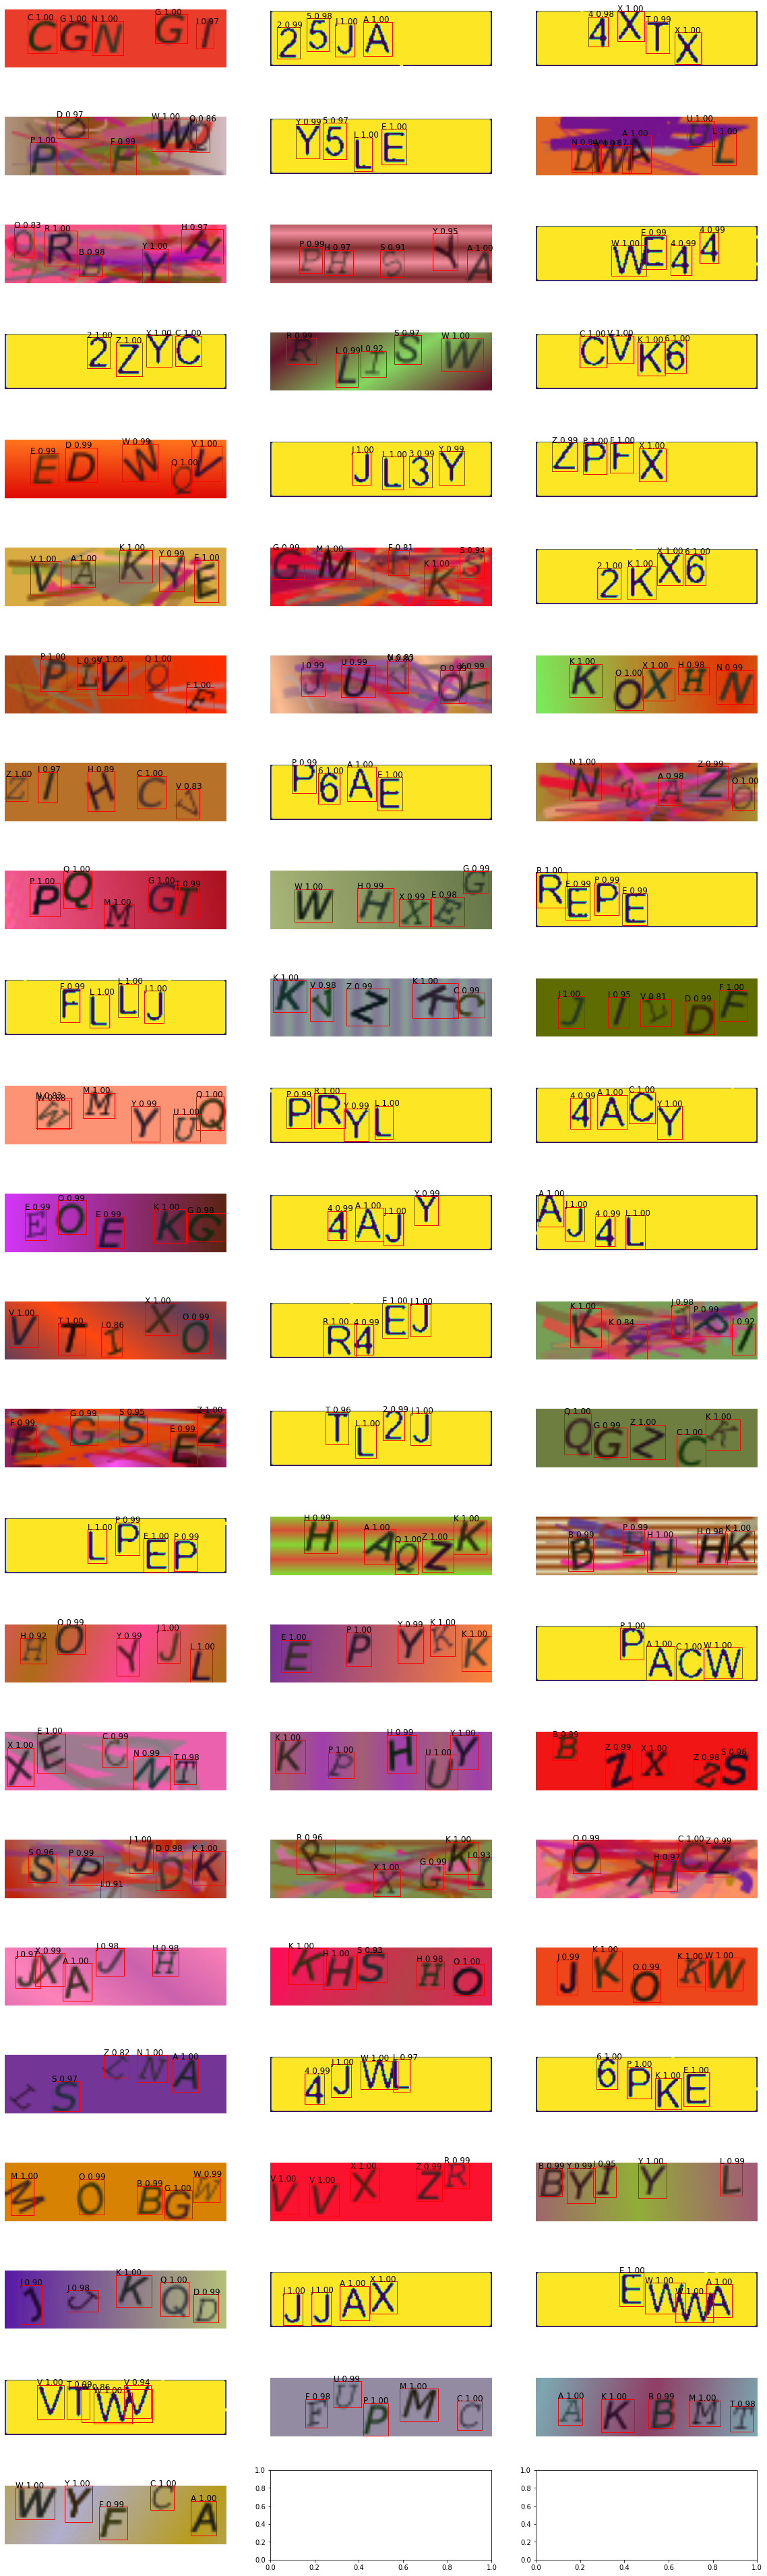

In [32]:
import matplotlib.patches as patches
from os.path import join

cntr = 0
threshold = 0.8

# Create figure and axes
fig,ax = plt.subplots(24, 3, figsize=(20, 70))

path = '/home/egor/job/CAPTCHA_recognition/data/labels+boxes/test'
for name in listdir(path):
    if 'jpg' not in name:
        continue
    full_name = join(path, name)
    pred = get_prediction(full_name, model, threshold)
    im = Image.open(full_name) 

    row, col = cntr // 3, cntr % 3
    # Display the image
    ax[row, col].imshow(im)

    # Create a Rectangle patch
    for ((x0, y0), (x1, y1)), letter, score in zip(pred[0], pred[1], pred[2]):
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0,y0),w,h,linewidth=1,edgecolor='r',facecolor='none')
        score = '{:.2f}'.format(score)
        ax[row, col].text(x0, y0, f'{letter} {score}', fontsize=12)
        ax[row, col].add_patch(rect)
    
    ax[row, col].axis('off')
    cntr += 1
plt.show()